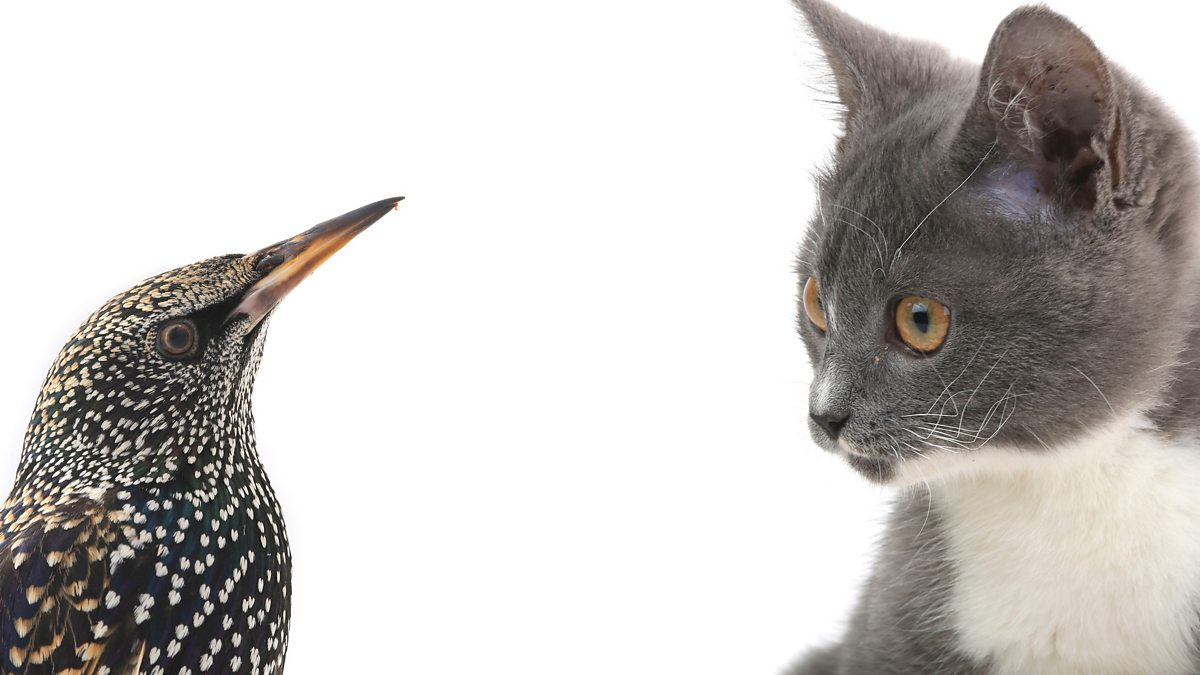

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">1. Import Libraries </h3>
    
</div>


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
import itertools
import librosa
import librosa.display
from tensorflow.keras import layers, models, callbacks
from keras.utils import plot_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.io import wavfile

import warnings
warnings.filterwarnings ('ignore')


<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">2. Preprocessing </h3>
    
</div>


In [18]:
# INPUT_DIR = '/kaggle/input/cats-vs-dogs-vs-birds-audio-classification/Animals'
INPUT_DIR = 'Animals'

files_in_dir = os.listdir(INPUT_DIR)

print(files_in_dir)

['bird', 'cat', 'dog']


C:\Users\hi\Desktop\projects\python_projects\ai_projects\tutorial\tut_ai\tut_audio_classify1\Animals\dog\0ab3b47d_nohash_0.wav


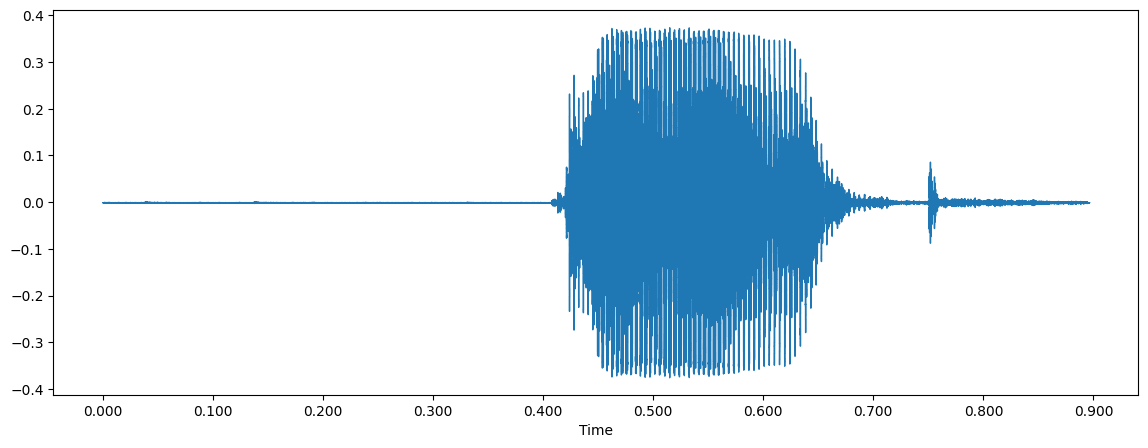

In [22]:
import IPython.display as ipd
import librosa
import librosa.display
from pathlib import Path

### Dog Sound
filename= Path.cwd() / INPUT_DIR / 'dog' / '0ab3b47d_nohash_0.wav'  # INPUT_DIR,'dog\0ab3b47d_nohash_0.wav')
print(filename)
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [23]:
sample_rate # number of sample per sec taken

22050

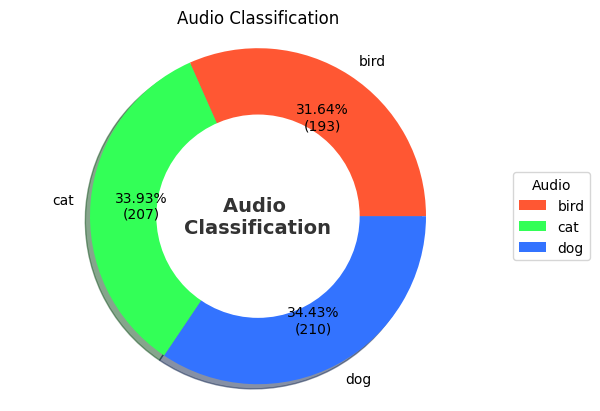

In [6]:
subdirectories = [subdir for subdir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, subdir))]
num_wav_files = []
for subdir in subdirectories:
    subdir_path = os.path.join(INPUT_DIR, subdir)
    wav_files = [file for file in os.listdir(subdir_path) if file.endswith('.wav')]
    num_wav_files.append(len(wav_files))

total_files = sum(num_wav_files)
percentages = [(num_files / total_files) * 100 for num_files in num_wav_files]

unique_emotion = subdirectories
colors = ['#FF5733', '#33FF57', '#3373FF']


explode = [0] * len(unique_emotion)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=num_wav_files, 
    labels=unique_emotion,
    autopct=lambda p: f'{p:.2f}%\n({int(p*total_files/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Audio \nClassification', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(unique_emotion, title="Audio", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  
plt.title('Audio Classification')

plt.show()

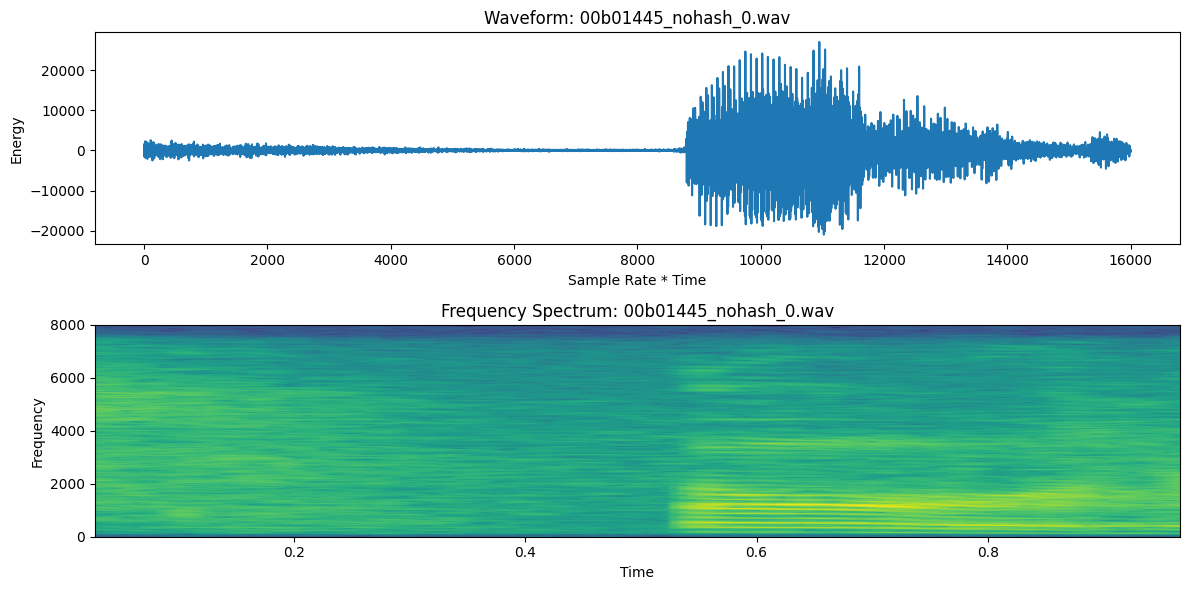

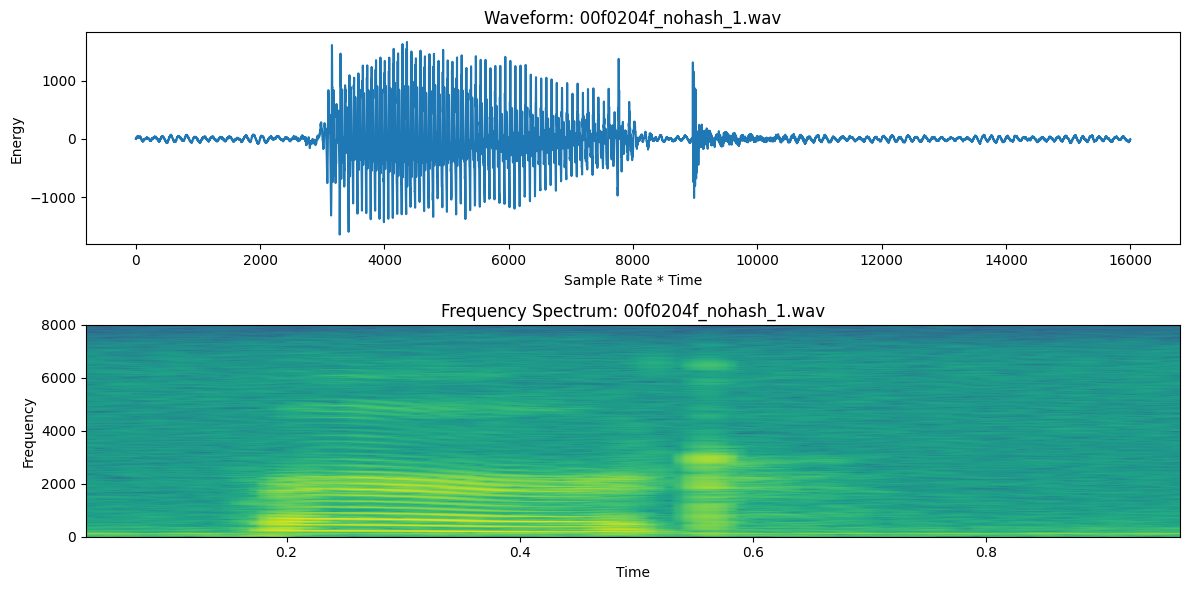

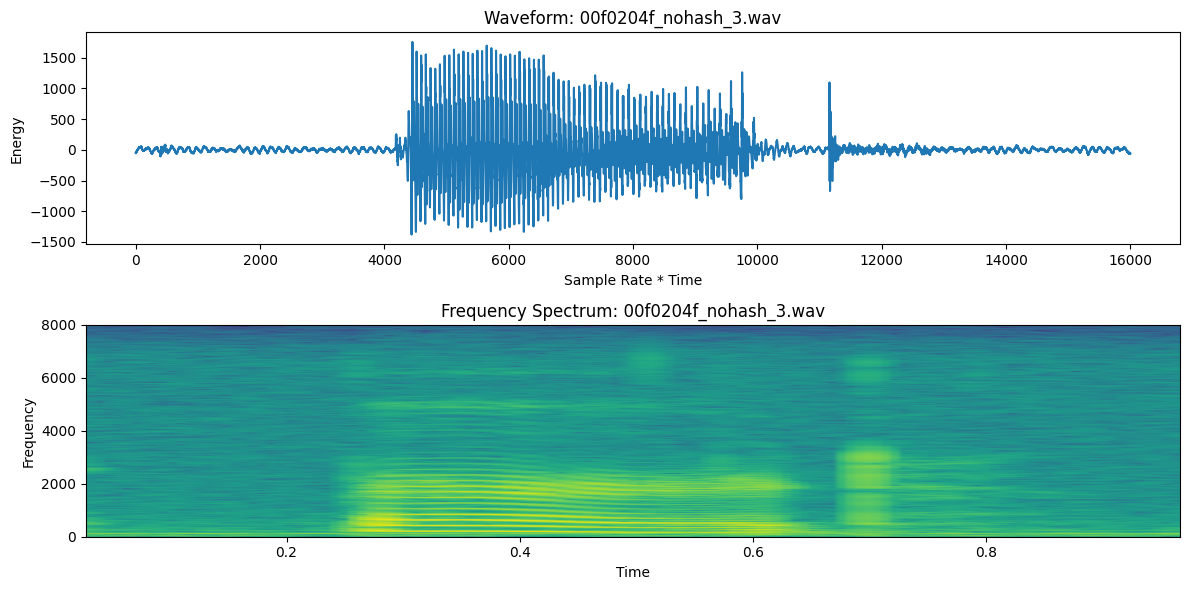

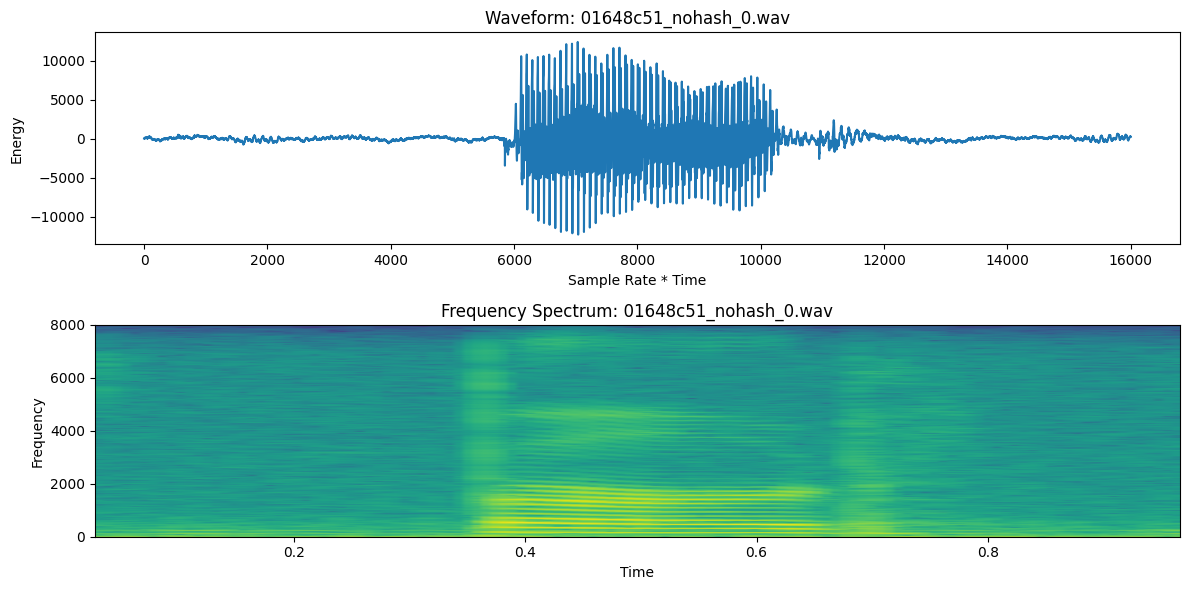

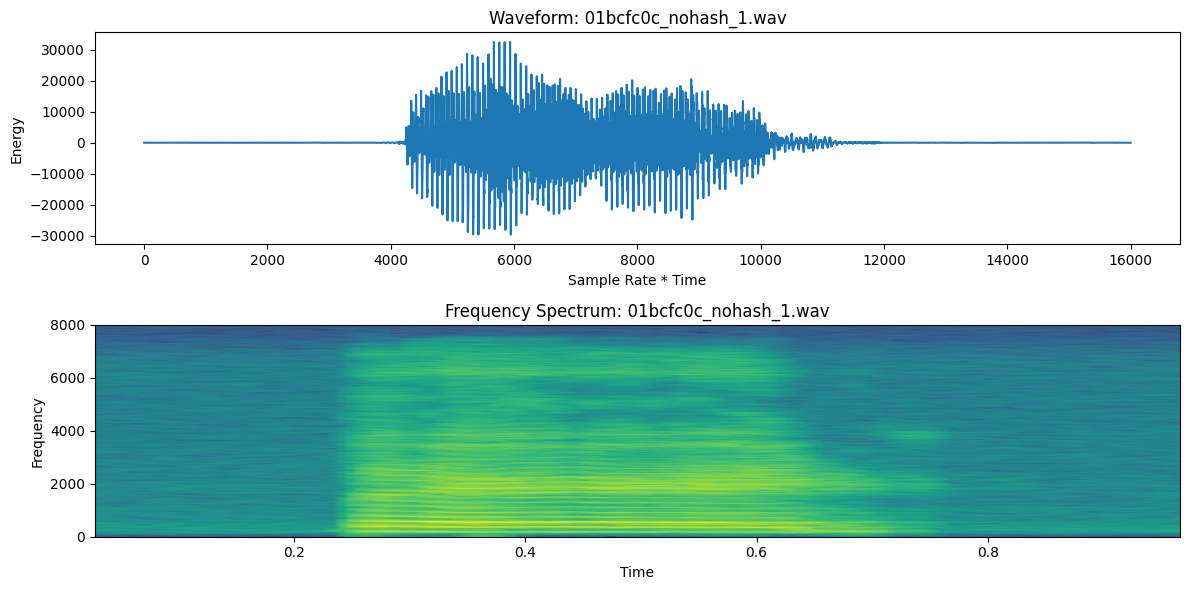

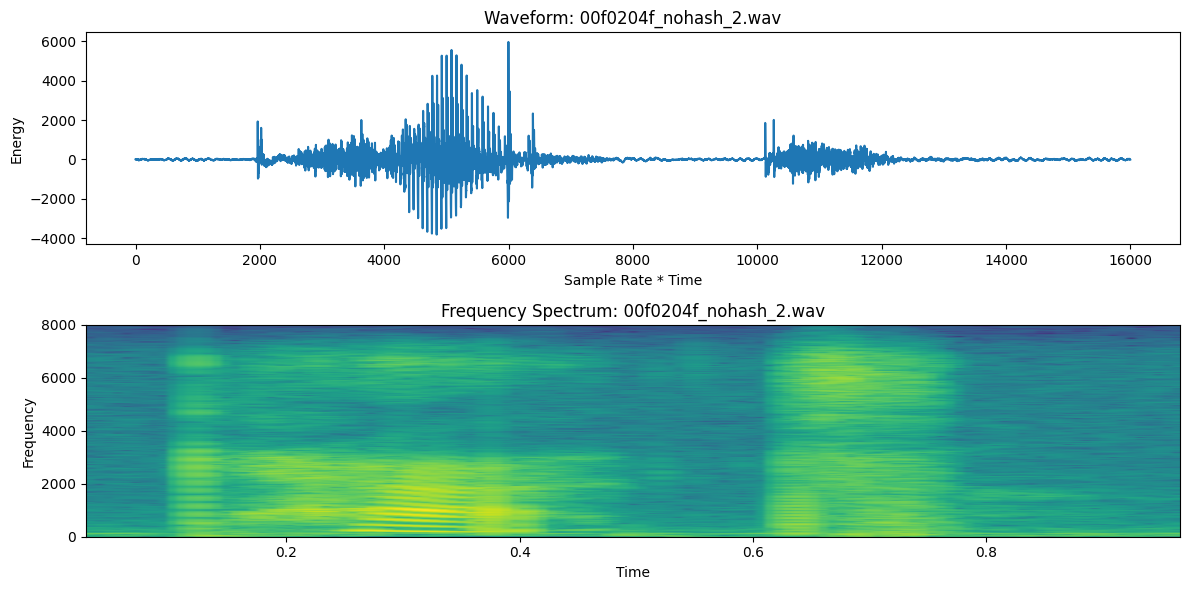

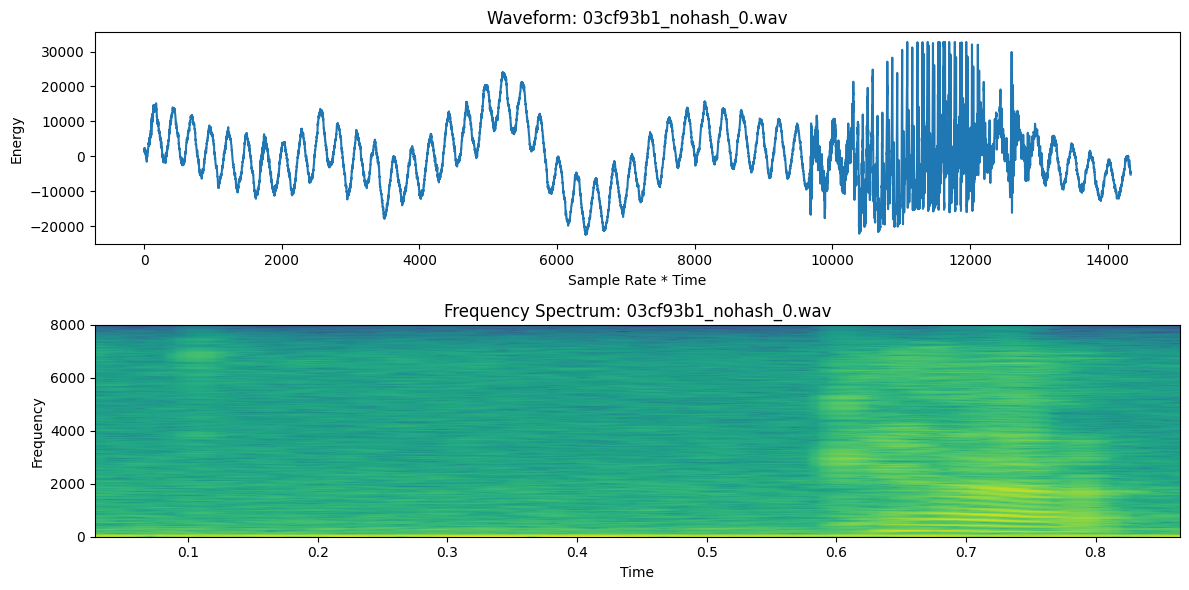

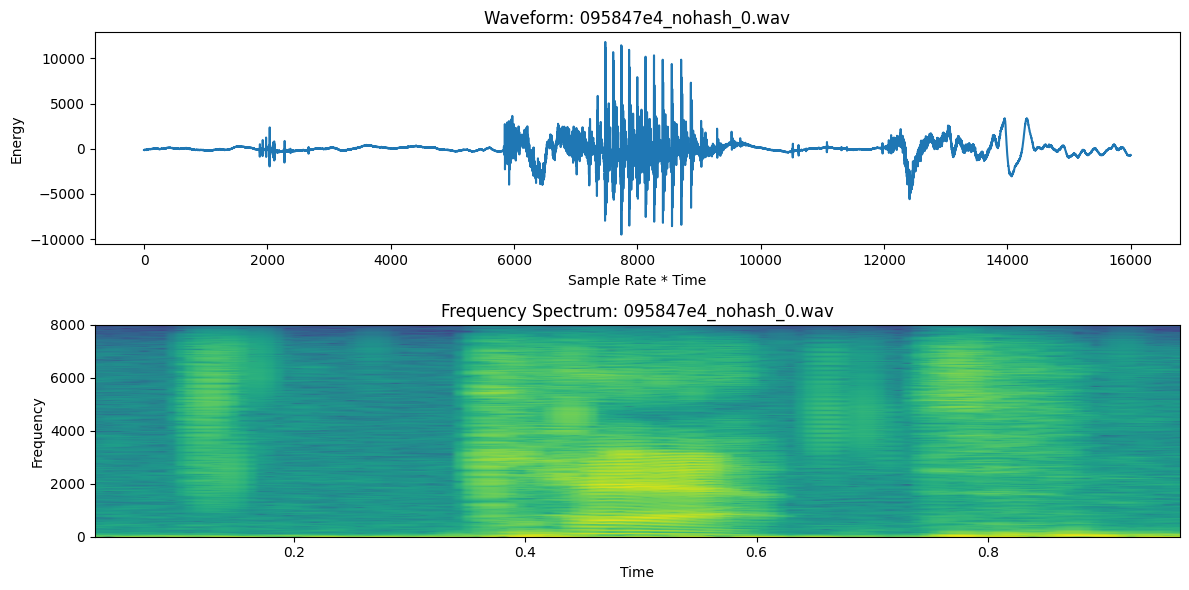

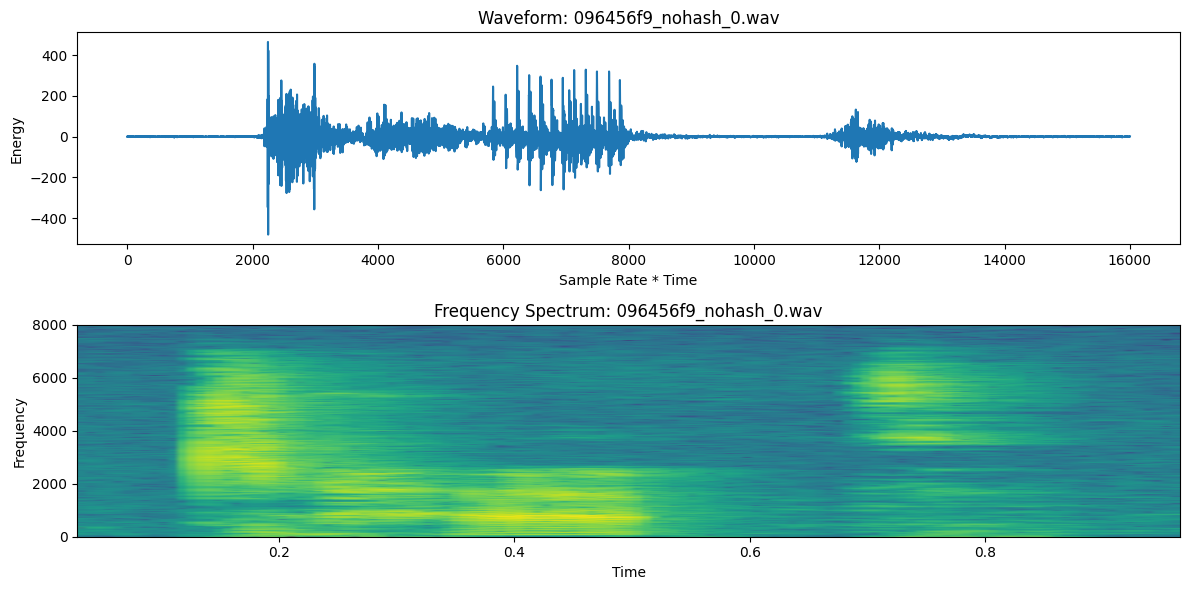

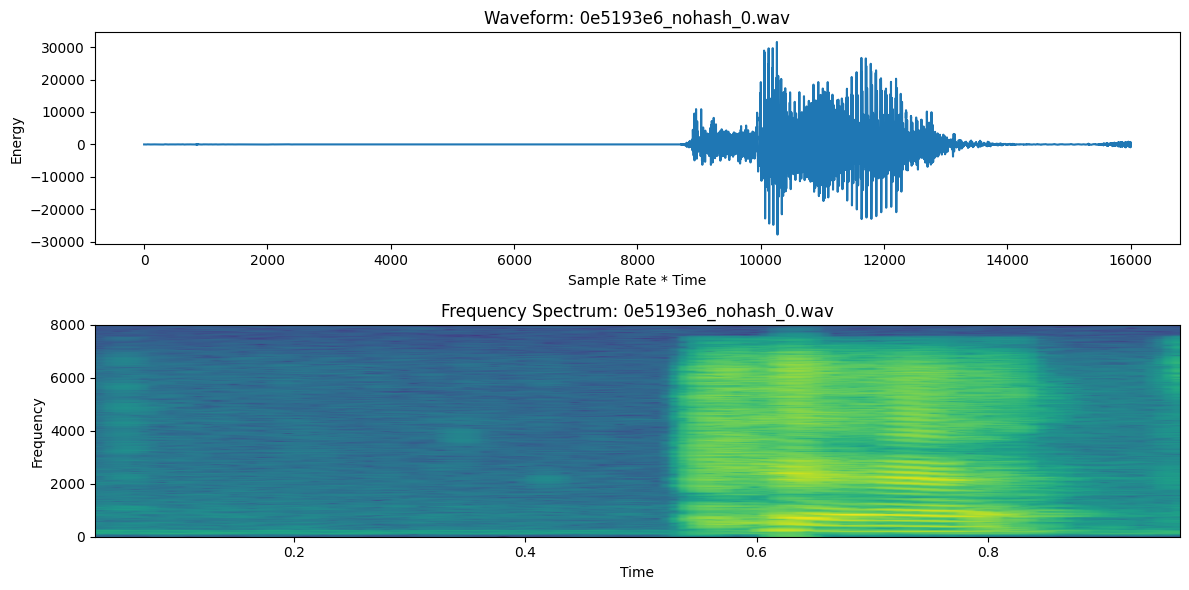

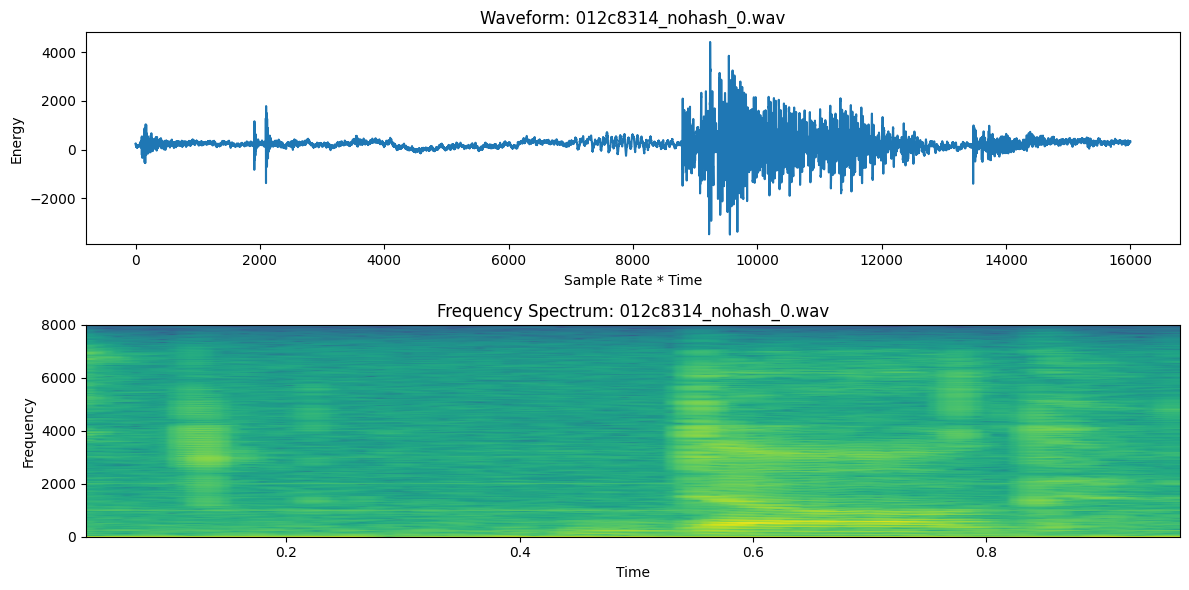

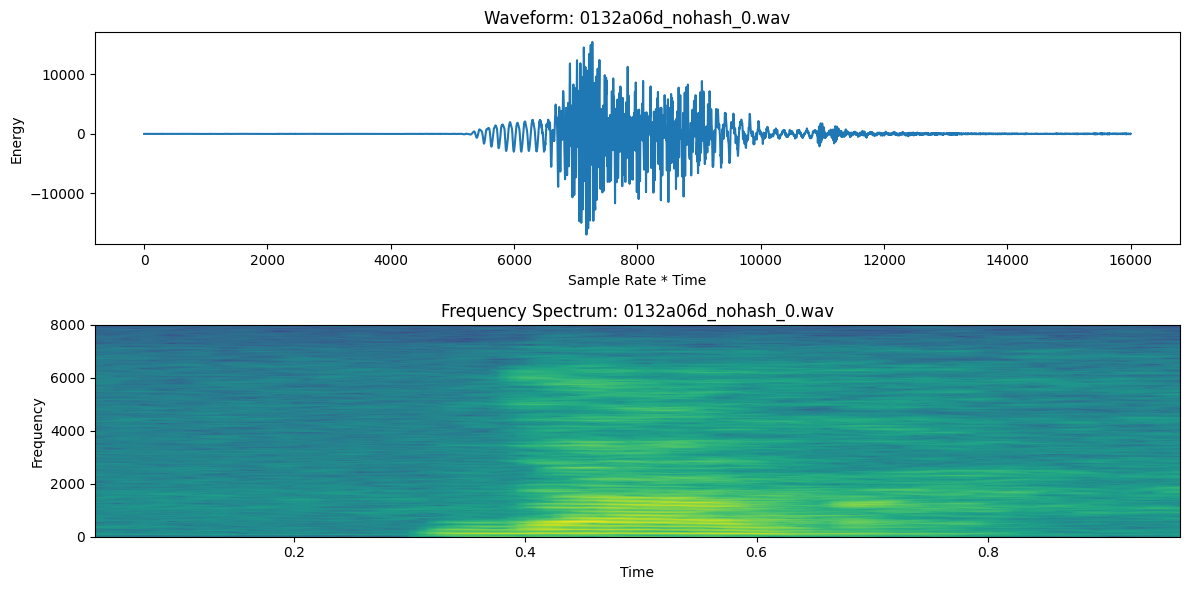

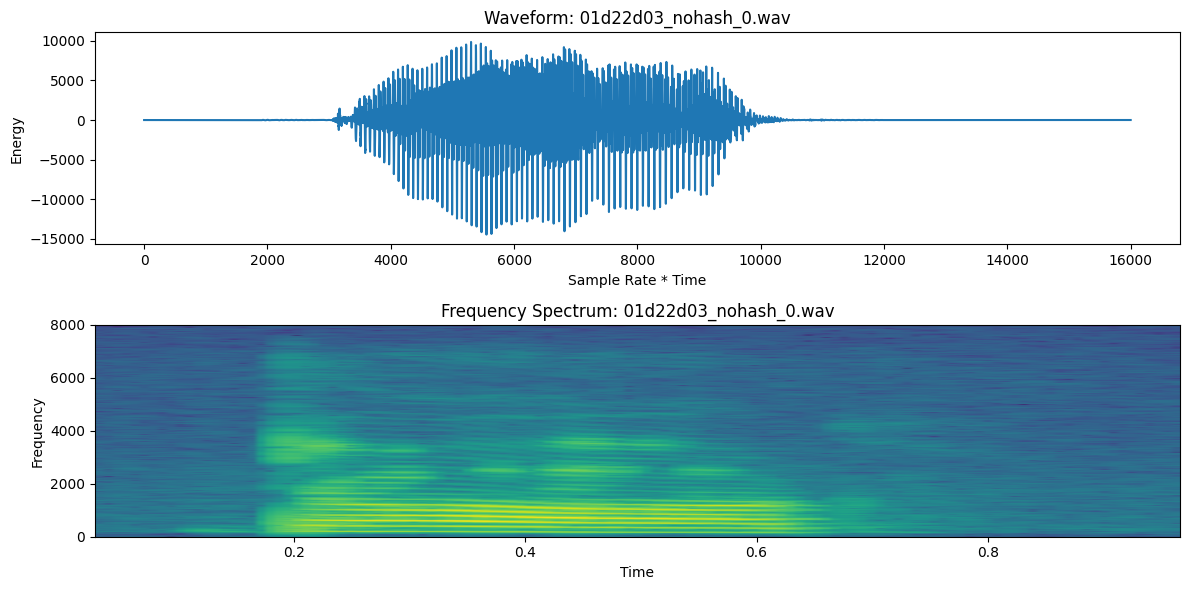

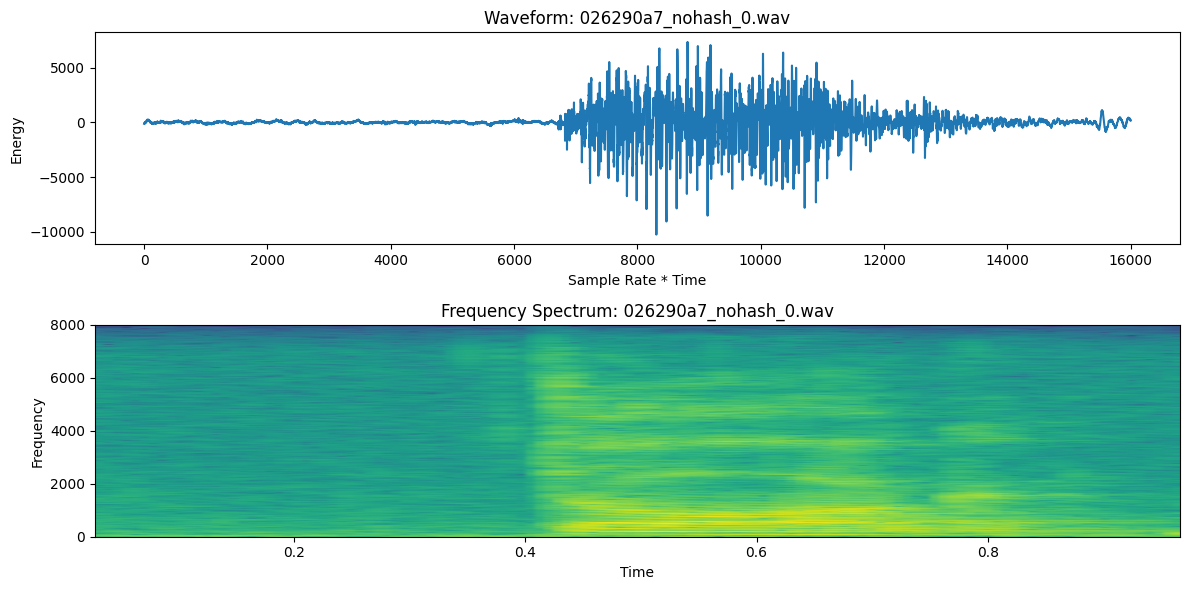

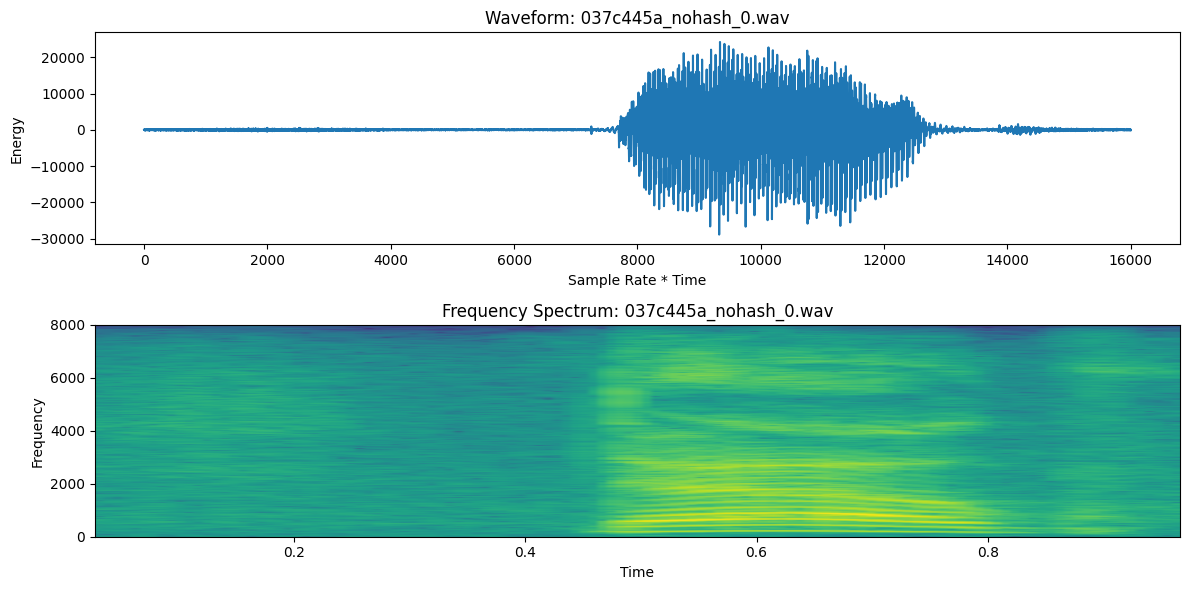

In [7]:
subdirectories = [subdir for subdir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, subdir))]

for subdir in subdirectories:
    subdir_path = os.path.join(INPUT_DIR, subdir)
    wav_files = [file for file in os.listdir(subdir_path) if file.endswith('.wav')]

    for i in range(min(5, len(wav_files))):
        file_path = os.path.join(subdir_path, wav_files[i])
        signal_wave = wave.open(file_path, 'r')
        sample_rate = 16000
        sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

        plt.figure(figsize=(12, 6))
        plt.subplot(211)
        plt.title(f'Waveform: {wav_files[i]}')
        plt.plot(sig)
        plt.xlabel('Sample Rate * Time')
        plt.ylabel('Energy')

        plt.subplot(212)
        plt.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
        plt.title(f'Frequency Spectrum: {wav_files[i]}')
        plt.xlabel('Time')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">3.Feature Extraction </h3>
    
</div>


In [8]:
def load_and_extract_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)  
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  
    return mel_spec_db

In [9]:
subdirectories = [subdir for subdir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, subdir))]

In [11]:
X = []
y = []
max_time_steps = 128  
for idx, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(INPUT_DIR, subdir)
    wav_files = [file for file in os.listdir(subdir_path) if file.endswith('.wav')]

    for wav_file in wav_files:
        file_path = os.path.join(subdir_path, wav_file)
        spectrogram = load_and_extract_spectrogram(file_path)
        if spectrogram.shape[1] < max_time_steps:
            pad_width = max_time_steps - spectrogram.shape[1]
            spectrogram_padded = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            X.append(spectrogram_padded)
        else:
            X.append(spectrogram[:, :max_time_steps])  # Trim if spectrogram has more time steps
        y.append(idx)  # Use class index as label
# Took 10 sec

In [12]:
X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">4.CNN Modeling </h3>
    
</div>


In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(256, activation='relu'),
    layers.Dense(len(subdirectories), activation='softmax')
])


model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,239,043 (19.99 MB)

 Trainable params: 5,239,043 (19.99 MB)

 Non-trainable params: 0 (0.00 B)

## Model architecure
![alt ModelArchitecture](model_architecture.png "Title")

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">4.Training and Validation </h3>
    
</div>


In [17]:

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping]) # TODO change epoch to 30 for better result


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.6740 - loss: 0.8727 - val_accuracy: 0.6557 - val_loss: 1.3823
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.7577 - loss: 0.6702 - val_accuracy: 0.8770 - val_loss: 0.3217
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.9006 - loss: 0.2838 - val_accuracy: 0.9098 - val_loss: 0.2389
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.9281 - loss: 0.1627 - val_accuracy: 0.9262 - val_loss: 0.2256
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.9505 - loss: 0.1598 - val_accuracy: 0.9180 - val_loss: 0.2966
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9721 - loss: 0.0956 - val_accuracy: 0.9426 - val_loss: 0.2362
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.9784 - loss: 0.0536 - val_accuracy: 0.9180 - val_loss: 0.4075


In [18]:
evaluation_result = model.evaluate(X_test, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9361 - loss: 0.2014 
Test Loss: 0.22563937306404114
Test Accuracy: 0.9262295365333557


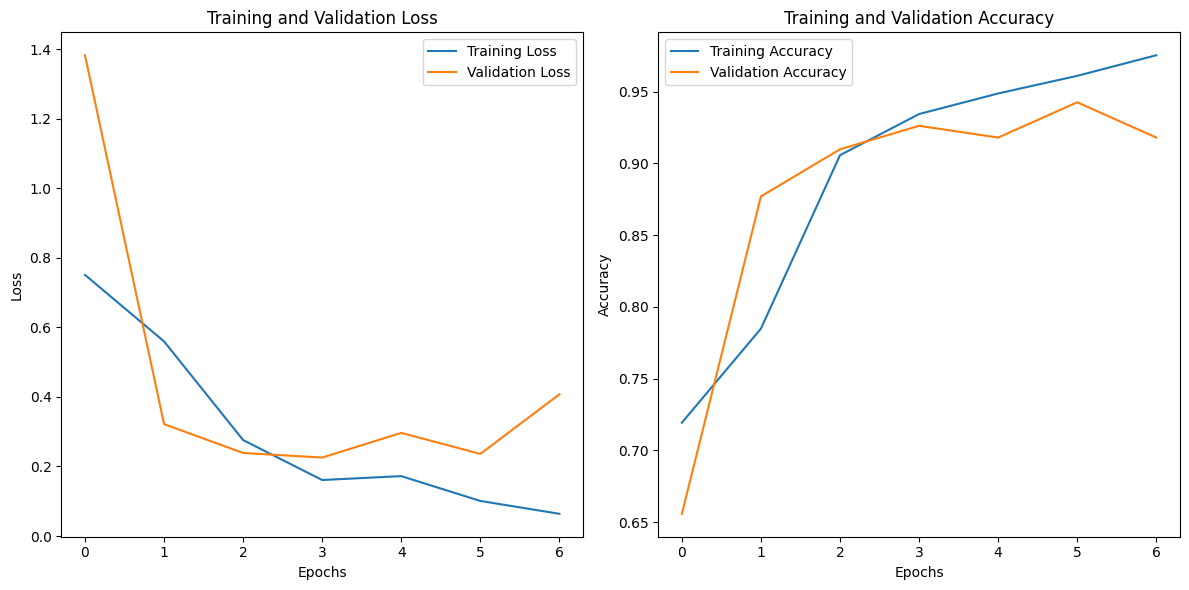

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 22px; font-weight: bold; color: #20639B; margin-bottom: 10px;">FINISH </h3>
    
</div>
